# Cài đặt các thư viện cần thiết

In [31]:
!pip install -q flwr[simulation]  pandas matplotlib scikit-learn torch

In [32]:
from collections import OrderedDict
from typing import List, Tuple
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pickle


import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr.server.client_proxy import ClientProxy
from flwr.common import Parameters, Scalar, FitRes, parameters_to_ndarrays
from typing import Optional, Union

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")


Training on cpu
Flower 1.13.0 / PyTorch 2.5.1


In [33]:
# Cấu hình thiết bị (CUDA hoặc CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
BATCH_SIZE = 16
NUM_CLIENTS = 10

# Dataset
Tập dữ liệu được sử dụng trong dự án này là tập dữ liệu SMS Spam Collection. Đây là một tập dữ liệu bao gồm các tin nhắn SMS được gán nhãn là "ham" (không phải spam) hoặc "spam".


## Định dạng dữ liệu
Tập dữ liệu bao gồm hai cột:
- `label`: Nhãn của tin nhắn, với giá trị `0` cho "ham" và `1` cho "spam".
- `text`: Nội dung của tin nhắn SMS.


In [35]:
# Đường dẫn đến tập dữ liệu
DATA_PATH = r"..\data\SMSSpamCollection"

# Đọc dữ liệu
data = pd.read_csv(DATA_PATH, sep='\t', header=None, names=["label", "text"])

# Chuyển đổi nhãn 'ham' và 'spam' thành 0 và 1
data["label"] = data["label"].map({"ham": 0, "spam": 1})


## Thống kê dữ liệu
- Tổng số dòng dữ liệu: 5572
- Các nhãn trong tập dữ liệu:
    - `ham`: 4825 tin nhắn
    - `spam`: 747 tin nhắn

In [36]:
num_rows = data.shape[0]
print(f"Number of rows in the dataset: {num_rows}")
data.head()

Number of rows in the dataset: 5572


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


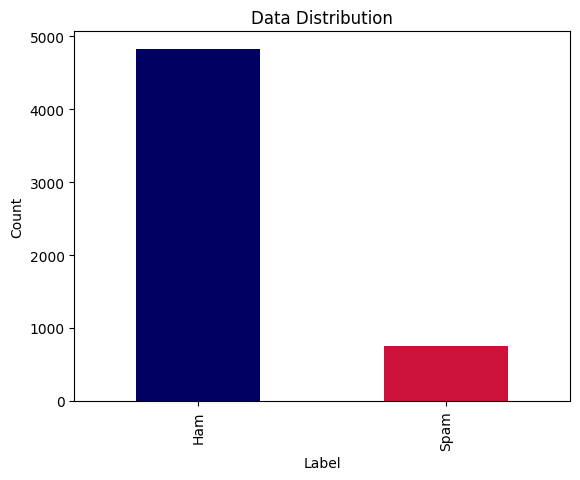

In [37]:
# Bar Chart for Data Distribution
data['label'].value_counts().plot(kind='bar', color=['#000062', '#CC123B'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Data Distribution')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.show()

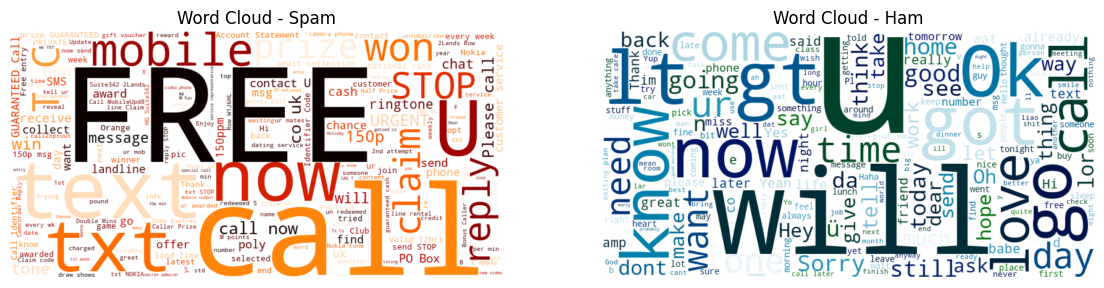

In [38]:
from wordcloud import WordCloud

# Tạo WordCloud cho spam và ham
spam_text = ' '.join(data[data['label'] == 1]['text'])
ham_text = ' '.join(data[data['label'] == 0]['text'])

plt.figure(figsize=(14, 7))

# WordCloud cho Spam
plt.subplot(1, 2, 1)
wordcloud_spam = WordCloud(width=800, height=400, background_color='white', colormap='gist_heat').generate(spam_text)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title("Word Cloud - Spam")
plt.axis('off')

# WordCloud cho Ham
plt.subplot(1, 2, 2)
wordcloud_ham = WordCloud(width=800, height=400, background_color='white', colormap='ocean').generate(ham_text)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title("Word Cloud - Ham")
plt.axis('off')

plt.show()


- No_of_Characters: Tổng số ký tự (character) trong tin nhắn SMS
- No_of_Words: Tổng số từ trong tin nhắn SMS.
- No_of_sentence:  Tổng số câu trong tin nhắn SMS

In [39]:
data["No_of_Characters"] = data["text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["text"]), axis=1).apply(len)

data.describe().T

,count,mean,std,min,25%,50%,75%,max
label,5572.0,0.134063,0.340751,0.0,0.0,0.0,0.0,1.0
No_of_Characters,5572.0,80.489950,59.942907,2.0,36.0,62.0,122.0,910.0
No_of_Words,5572.0,18.842426,13.851947,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,2.006102,1.539977,1.0,1.0,2.0,3.0,38.0


<Figure size 1200x800 with 0 Axes>

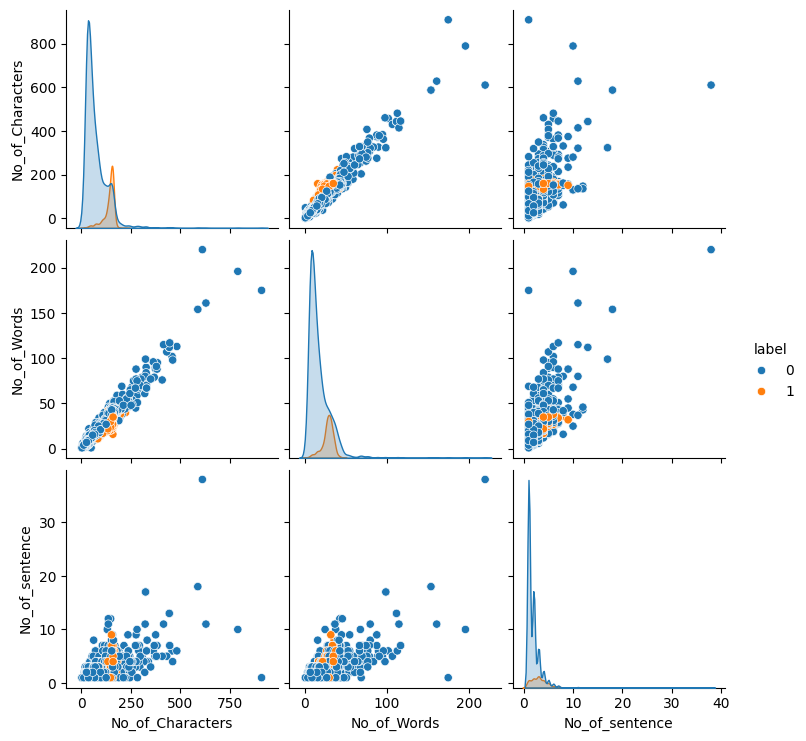

In [40]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="label")
plt.show(fg)

## VECTORIZATION
- Sử dụng `TfidfVectorizer` để vector hóa nội dung tin nhắn.

- TF (Term Frequency): đo lường tần suất xuất hiện của một từ trong một tài liệu.

- IDF (Inverse Documnet Frequency): ánh giá mức độ quan trọng của một từ trong toàn bộ tập tài liệu.

- Vectorizing: chuyển đổi văn bản thành vector

In [41]:
class SMSDataset(Dataset):
    def __init__(self, texts, labels, vectorizer):
        self.texts = texts
        self.labels = labels
        self.vectorizer = vectorizer

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text_vector = self.vectorizer.transform([self.texts[idx]]).toarray().squeeze()
        label = self.labels[idx]
        return torch.tensor(text_vector, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

def load_datasets(partition_id: int):
    print(f"Loading dataset for partition ID: {partition_id}")

    # Load raw data
    data = pd.read_csv(DATA_PATH, sep="\t", header=None, names=["label", "text"])
    data["label"] = data["label"].map({"ham": 0, "spam": 1})

    # Vectorize text data
    vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
    vectorizer.fit(data["text"])

    # Split into NUM_CLIENTS partitions
    indices = np.arange(len(data))
    np.random.seed(42)
    np.random.shuffle(indices)
    split_indices = np.array_split(indices, NUM_CLIENTS)

    # Select partition
    partition_indices = split_indices[partition_id]
    partition_data = data.iloc[partition_indices]

    # Train/val split
    train_data, val_data = train_test_split(partition_data, test_size=0.1, random_state=42)
    train_dataset = SMSDataset(train_data["text"].tolist(), train_data["label"].tolist(), vectorizer)
    val_dataset = SMSDataset(val_data["text"].tolist(), val_data["label"].tolist(), vectorizer)

    # Dataloaders
    trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # Test set
    test_data = data.iloc[split_indices[-1]]
    test_dataset = SMSDataset(test_data["text"].tolist(), test_data["label"].tolist(), vectorizer)
    testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    print(f"Partition {partition_id}: Train {len(train_data)}, Val {len(val_data)}, Test {len(test_data)}")
    return trainloader, valloader, testloader


# Train model

In [42]:
class Net(nn.Module):
    def __init__(self, input_dim: int):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # 2 output classes (ham, spam)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [43]:
# Lấy trainloader từ partition đầu tiên
trainloader, valloader, testloader = load_datasets(partition_id=0)

# Số chiều của đầu vào từ vectorizer
input_dim = 5000  # (đã được đặt trong load_datasets max_features=5000)

# Khởi tạo mô hình
net = Net(input_dim).to(DEVICE)
print(net)


Loading dataset for partition ID: 0
Partition 0: Train 502, Val 56, Test 557
Net(
  (fc1): Linear(in_features=5000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [44]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        correct, total = 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader)
        epoch_acc = correct / total
        if verbose:
            print(f"Train loss {epoch_loss}, Accuracy {epoch_acc}")

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = net(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader)
    accuracy = correct / total
    return loss, accuracy


In [45]:
# Load dữ liệu
trainloader, valloader, testloader = load_datasets(partition_id=0)

# Huấn luyện mô hình
for epoch in range(10):
    print(f"Epoch {epoch+1}:")
    train(net, trainloader, epochs=1, verbose=True)
    val_loss, val_accuracy = test(net, valloader)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

test_loss, test_accuracy = test(net, testloader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Loading dataset for partition ID: 0
Partition 0: Train 502, Val 56, Test 557
Epoch 1:
Train loss 0.6639325059950352, Accuracy 0.5756972111553785
Validation Loss: 0.5385, Accuracy: 0.8214
Epoch 2:
Train loss 0.379467778140679, Accuracy 0.8745019920318725
Validation Loss: 0.3280, Accuracy: 0.8214
Epoch 3:
Train loss 0.2018735697492957, Accuracy 0.8844621513944223
Validation Loss: 0.2335, Accuracy: 0.8571
Epoch 4:
Train loss 0.10602320288307965, Accuracy 0.9780876494023905
Validation Loss: 0.1752, Accuracy: 0.8929
Epoch 5:
Train loss 0.06306353723266511, Accuracy 0.9940239043824701
Validation Loss: 0.1324, Accuracy: 0.9286
Epoch 6:
Train loss 0.035559921872845734, Accuracy 0.99800796812749
Validation Loss: 0.1237, Accuracy: 0.9464
Epoch 7:
Train loss 0.0173919843045951, Accuracy 0.99800796812749
Validation Loss: 0.0928, Accuracy: 0.9464
Epoch 8:
Train loss 0.009492251553808728, Accuracy 0.99800796812749
Validation Loss: 0.1056, Accuracy: 0.9464
Epoch 9:
Train loss 0.005882543498330506, Ac

In [46]:
# prompt: test thử độ chính xác của mô hình bằng input nhập vào 1 sms để đoán

def predict_sms(sms_text: str):
    """Predicts whether an SMS is spam or ham using the trained model."""

    # Vectorize the input SMS using the same vectorizer used during training
    vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
    vectorizer.fit(data["text"])  # Fit the vectorizer on the entire dataset
    sms_vector = vectorizer.transform([sms_text]).toarray().squeeze()
    sms_tensor = torch.tensor(sms_vector, dtype=torch.float32).to(DEVICE)

    # Make a prediction using the trained model
    with torch.no_grad():
        net.eval()  # Set the model to evaluation mode
        output = net(sms_tensor)
        _, predicted = torch.max(output.data, 0)  # Get the class with highest probability

    # Return the prediction (0 for ham, 1 for spam)
    return predicted.item()

# Example usage
input_sms = input("Enter an SMS message: ")
prediction = predict_sms(input_sms)

print("Input SMS: ", input_sms)
if prediction == 0:
    print("Prediction: Ham")
else:
    print("Prediction: Spam")

Input SMS:  You win a prize
Prediction: Spam


# Federated Learning

In [47]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [48]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [49]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    input_dim = 5000  # (đã được đặt trong load_datasets max_features=5000)

    # Khởi tạo mô hình
    net = Net(input_dim).to(DEVICE)



    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    return FlowerClient(net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [50]:
def weighted_average(metrics: List[Tuple[int, dict]]) -> dict:
    """
    Compute weighted average for metrics.
    
    Args:
        metrics: List of tuples (num_examples, metrics_dict).
    
    Returns:
        dict: Aggregated metrics with weighted averages.
    """
    # Ensure there are metrics to aggregate
    if not metrics:
        return {}

    # Initialize storage for weighted sums
    weighted_sums = {}
    total_examples = 0

    for num_examples, metric_dict in metrics:
        total_examples += num_examples
        for key, value in metric_dict.items():
            if key not in weighted_sums:
                weighted_sums[key] = 0
            weighted_sums[key] += num_examples * value

    # Compute weighted averages
    aggregated_metrics = {
        key: weighted_sums[key] / total_examples for key in weighted_sums
    }
    return aggregated_metrics


In [51]:
# Custom SaveModelStrategy implementation
class SaveModelStrategy(FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[Union[tuple[ClientProxy, FitRes], BaseException]],
    ) -> tuple[Optional[Parameters], dict[str, Scalar]]:

        # Call aggregate_fit from the base class (FedAvg)
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(
            server_round, results, failures
        )

        if aggregated_parameters is not None:
            # Convert `Parameters` to `list[np.ndarray]`
            aggregated_ndarrays = parameters_to_ndarrays(aggregated_parameters)

            # Save aggregated weights for each round
            print(f"Saving round {server_round} aggregated weights...")
            np.savez(f"round-{server_round}-weights.npz", *aggregated_ndarrays)

            # Save the final model at the end of training
            if server_round == 5:
                with open("final_model.pkl", "wb") as f:
                    pickle.dump(aggregated_ndarrays, f)
                print("Final model saved as 'final_model.pkl'")
                # Lưu dưới dạng PyTorch
                torch.save(aggregated_ndarrays, "final_model.pth")
                print("Final model saved as 'final_model.pth'")

        return aggregated_parameters, aggregated_metrics

In [52]:

# Define the server function
def server_fn(context: Context) -> ServerAppComponents:
    # Use the custom SaveModelStrategy
    strategy = SaveModelStrategy(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        fit_metrics_aggregation_fn=weighted_average,
        evaluate_metrics_aggregation_fn=weighted_average,
    )

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=5)

    return ServerAppComponents(strategy=strategy, config=config)


# Create a new server instance with the SaveModelStrategy
server = ServerApp(server_fn=server_fn)

In [53]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [54]:
import os

# Disable oneDNN custom operations to avoid floating-point round-off errors
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Import TensorFlow and other required libraries
import tensorflow as tf

# Initialize TensorFlow
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [55]:
# Run simulation
history = run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
    verbose_logging=True
)


DEBUG 2024-12-01 22:30:40,383:     Asyncio event loop already running.
DEBUG 2024-12-01 22:30:40,386:     Logger propagate set to False
DEBUG 2024-12-01 22:30:40,386:     Pre-registering run with id 14536789694017138537
DEBUG 2024-12-01 22:30:40,387:     Using InMemoryState
DEBUG 2024-12-01 22:30:40,388:     Using InMemoryState
INFO 2024-12-01 22:30:40,690:      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
DEBUG 2024-12-01 22:30:40,693:     Buffer time delay: 5s
INFO 2024-12-01 22:30:40,694:      
INFO 2024-12-01 22:30:40,696:      [INIT]
INFO 2024-12-01 22:30:40,697:      Requesting initial parameters from one random client
DEBUG 2024-12-01 22:30:45,702:     Using InMemoryState
DEBUG 2024-12-01 22:30:45,703:     Registered 10 nodes
DEBUG 2024-12-01 22:30:45,703:     Supported backends: ['ray']
DEBUG 2024-12-01 22:30:45,705:     Initialising: RayBackend
DEBUG 2024-12-01 22:30:45,705:     Backend config: {'client_resources': {'num_cpus': 1, 'num_gpus': 0.0}, 'init_a

(ClientAppActor pid=620) Loading dataset for partition ID: 7
(ClientAppActor pid=620) Partition 7: Train 501, Val 56, Test 557
(ClientAppActor pid=620) Loading dataset for partition ID: 0
(ClientAppActor pid=620) Partition 0: Train 502, Val 56, Test 557
(ClientAppActor pid=10356) Loading dataset for partition ID: 9
(ClientAppActor pid=17100) Loading dataset for partition ID: 4
(ClientAppActor pid=10356) Partition 9: Train 501, Val 56, Test 557


INFO 2024-12-01 22:31:43,938:      aggregate_fit: received 10 results and 0 failures
INFO 2024-12-01 22:31:44,039:      configure_evaluate: strategy sampled 5 clients (out of 10)


Saving round 1 aggregated weights...
(ClientAppActor pid=17100) Loading dataset for partition ID: 9 [repeated 8x across cluster]
(ClientAppActor pid=18872) Partition 1: Train 502, Val 56, Test 557 [repeated 8x across cluster]


INFO 2024-12-01 22:31:44,633:      aggregate_evaluate: received 5 results and 0 failures
INFO 2024-12-01 22:31:44,634:      
INFO 2024-12-01 22:31:44,634:      [ROUND 2]
INFO 2024-12-01 22:31:44,634:      configure_fit: strategy sampled 10 clients (out of 10)
INFO 2024-12-01 22:31:47,566:      aggregate_fit: received 10 results and 0 failures
INFO 2024-12-01 22:31:47,612:      configure_evaluate: strategy sampled 5 clients (out of 10)


Saving round 2 aggregated weights...


INFO 2024-12-01 22:31:48,097:      aggregate_evaluate: received 5 results and 0 failures
INFO 2024-12-01 22:31:48,099:      
INFO 2024-12-01 22:31:48,099:      [ROUND 3]
INFO 2024-12-01 22:31:48,100:      configure_fit: strategy sampled 10 clients (out of 10)
INFO 2024-12-01 22:31:50,893:      aggregate_fit: received 10 results and 0 failures
INFO 2024-12-01 22:31:50,948:      configure_evaluate: strategy sampled 5 clients (out of 10)


Saving round 3 aggregated weights...
(ClientAppActor pid=17100) Loading dataset for partition ID: 5 [repeated 30x across cluster]
(ClientAppActor pid=27340) Partition 4: Train 501, Val 56, Test 557 [repeated 30x across cluster]


INFO 2024-12-01 22:31:51,417:      aggregate_evaluate: received 5 results and 0 failures
INFO 2024-12-01 22:31:51,418:      
INFO 2024-12-01 22:31:51,419:      [ROUND 4]
INFO 2024-12-01 22:31:51,419:      configure_fit: strategy sampled 10 clients (out of 10)
INFO 2024-12-01 22:31:54,042:      aggregate_fit: received 10 results and 0 failures
INFO 2024-12-01 22:31:54,094:      configure_evaluate: strategy sampled 5 clients (out of 10)


Saving round 4 aggregated weights...


INFO 2024-12-01 22:31:54,802:      aggregate_evaluate: received 5 results and 0 failures
INFO 2024-12-01 22:31:54,803:      
INFO 2024-12-01 22:31:54,803:      [ROUND 5]
INFO 2024-12-01 22:31:54,805:      configure_fit: strategy sampled 10 clients (out of 10)
INFO 2024-12-01 22:31:57,794:      aggregate_fit: received 10 results and 0 failures
INFO 2024-12-01 22:31:57,921:      configure_evaluate: strategy sampled 5 clients (out of 10)


Saving round 5 aggregated weights...
Final model saved as 'final_model.pkl'
Final model saved as 'final_model.pth'
(ClientAppActor pid=10356) Loading dataset for partition ID: 6 [repeated 30x across cluster]
(ClientAppActor pid=23800) Partition 1: Train 502, Val 56, Test 557 [repeated 30x across cluster]


INFO 2024-12-01 22:31:58,526:      aggregate_evaluate: received 5 results and 0 failures
INFO 2024-12-01 22:31:58,530:      
INFO 2024-12-01 22:31:58,531:      [SUMMARY]
INFO 2024-12-01 22:31:58,532:      Run finished 5 round(s) in 31.32s
INFO 2024-12-01 22:31:58,538:      	History (loss, distributed):
INFO 2024-12-01 22:31:58,539:      		round 1: 0.4898822963237762
INFO 2024-12-01 22:31:58,539:      		round 2: 0.2739693634212017
INFO 2024-12-01 22:31:58,541:      		round 3: 0.20376473069190978
INFO 2024-12-01 22:31:58,541:      		round 4: 0.1520536219701171
INFO 2024-12-01 22:31:58,542:      		round 5: 0.14339209180325269
INFO 2024-12-01 22:31:58,543:      	History (metrics, distributed, evaluate):
INFO 2024-12-01 22:31:58,543:      	{'accuracy': [(1, 0.8857142857142856),
INFO 2024-12-01 22:31:58,544:      	              (2, 0.8821428571428571),
INFO 2024-12-01 22:31:58,544:      	              (3, 0.8857142857142858),
INFO 2024-12-01 22:31:58,545:      	              (4, 0.9428571428

(ClientAppActor pid=27340) Loading dataset for partition ID: 9 [repeated 4x across cluster]
(ClientAppActor pid=36204) Partition 4: Train 501, Val 56, Test 557 [repeated 5x across cluster]


DEBUG 2024-12-01 22:32:01,188:     Terminated RayBackend
DEBUG 2024-12-01 22:32:01,193:     Stopping Simulation Engine now.


# Test model

In [30]:
def predict_sms_with_final_model(sms_text: str):
    """Predicts whether an SMS is spam or ham using the final trained model."""

    # Load the final model weights
    final_model_weights = torch.load("final_model.pth")

    # Initialize the model
    final_model = Net(input_dim).to(DEVICE)

    # Set the model parameters
    set_parameters(final_model, final_model_weights)

    # Vectorize the input SMS using the same vectorizer used during training
    vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
    vectorizer.fit(data["text"])  # Fit the vectorizer on the entire dataset
    sms_vector = vectorizer.transform([sms_text]).toarray().squeeze()
    sms_tensor = torch.tensor(sms_vector, dtype=torch.float32).to(DEVICE)

    # Make a prediction using the trained model
    with torch.no_grad():
        final_model.eval()  # Set the model to evaluation mode
        output = final_model(sms_tensor)
        _, predicted = torch.max(output.data, 0)  # Get the class with highest probability

    # Return the prediction (0 for ham, 1 for spam)
    return predicted.item()

# Example usage
input_sms = input("Enter an SMS message: ")
prediction = predict_sms_with_final_model(input_sms)

print("Input SMS: ", input_sms)
if prediction == 0:
    print("Prediction: Ham")
else:
    print("Prediction: Spam")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22292\2578444343.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model_weights = torch.load("final_model.pth")


Input SMS:  You have won a iPhone
Prediction: Spam


# Thống kê

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36784\256817350.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model_weights = torch.load("final_model.pth")


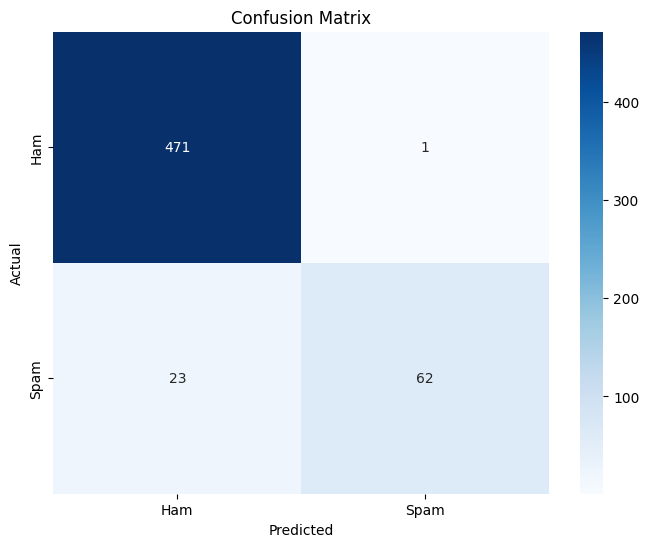

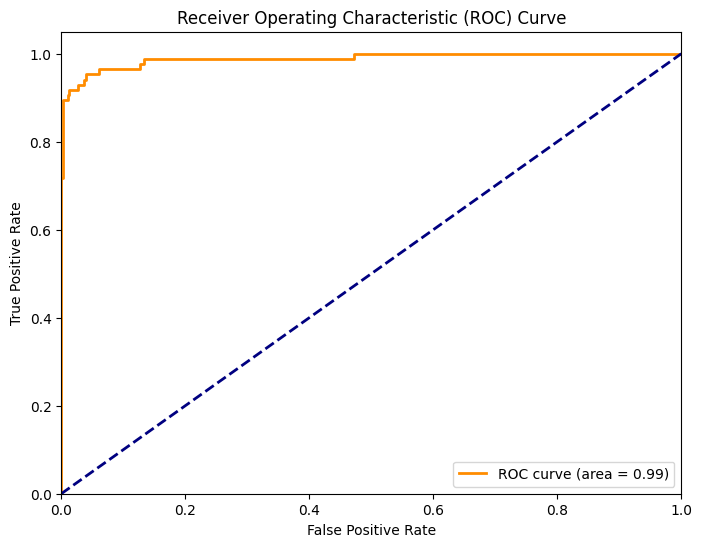

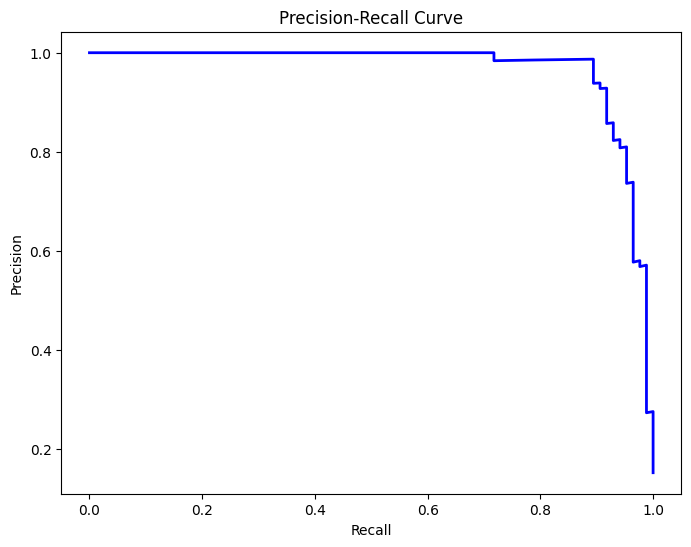

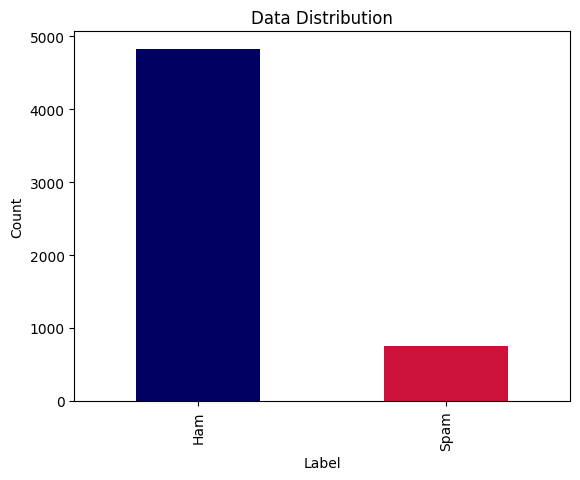

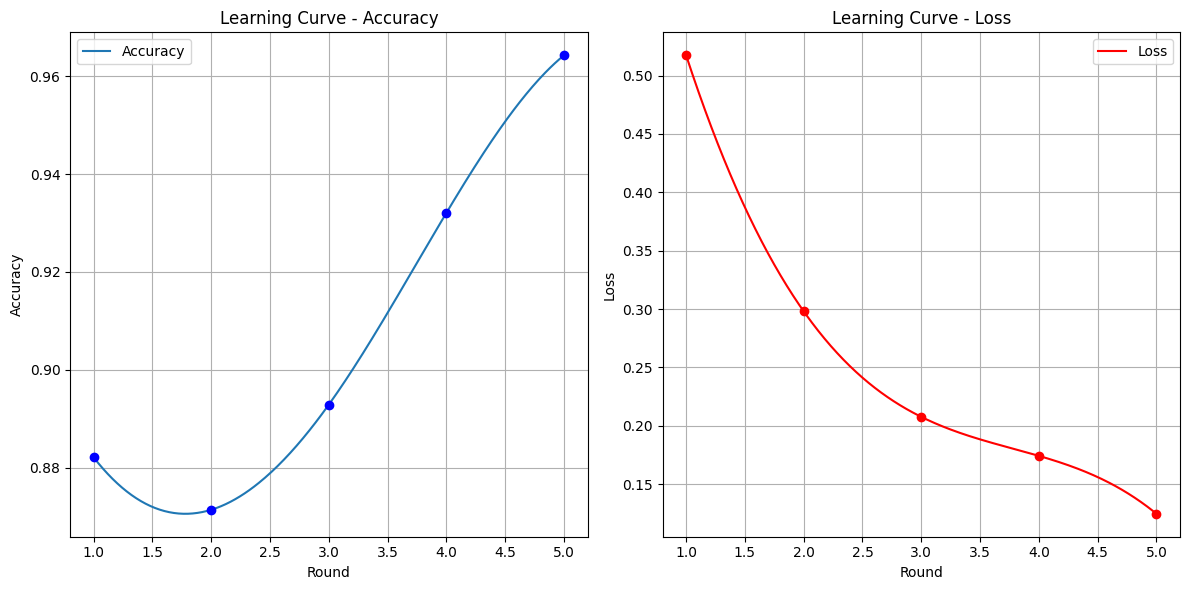

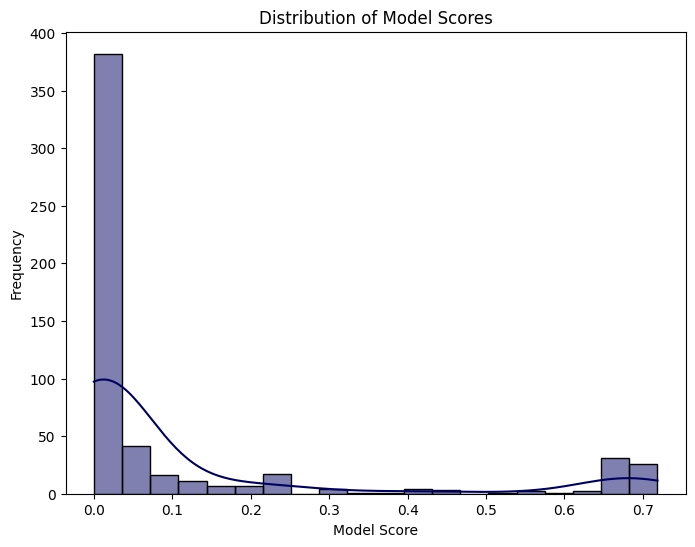

In [30]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
import seaborn as sns

# Load the final model weights
final_model_weights = torch.load("final_model.pth")

# Initialize the model
final_model = Net(input_dim).to(DEVICE)

# Set the model parameters
set_parameters(final_model, final_model_weights)

# Evaluate the model on the test set
test_loss, test_accuracy = test(final_model, testloader)

# Make predictions on the test set
final_model.eval()
all_labels = []
all_preds = []
all_probs = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = final_model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Bar Chart for Data Distribution
data['label'].value_counts().plot(kind='bar', color=['#000062', '#CC123B'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Data Distribution')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.show()

# Learning Curve
from scipy.interpolate import make_interp_spline

# Original data
history_acc = [0.8821, 0.8714, 0.8929, 0.9321, 0.9643]
history_loss = [0.5174, 0.2981, 0.2077, 0.1743, 0.1247]

# Create smooth curves
X = np.array(range(1, len(history_acc) + 1))
X_smooth = np.linspace(X.min(), X.max(), 300)

# Interpolate data
spl_acc = make_interp_spline(X, history_acc, k=3)
spl_loss = make_interp_spline(X, history_loss, k=3)
acc_smooth = spl_acc(X_smooth)
loss_smooth = spl_loss(X_smooth)

# Plot
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(X_smooth, acc_smooth, '-', label='Accuracy')
plt.plot(X, history_acc, 'o', color='blue')  # Original points
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Accuracy')
plt.grid(True)
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(X_smooth, loss_smooth, '-', label='Loss', color='red')
plt.plot(X, history_loss, 'o', color='red')  # Original points
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Learning Curve - Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Distribution of Model Scores
plt.figure(figsize=(8, 6))
sns.histplot(all_probs, bins=20, kde=True, color='#000062')
plt.xlabel('Model Score')
plt.ylabel('Frequency')
plt.title('Distribution of Model Scores')
plt.show()